In [2]:
import sys
import os
# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))
import logging
import warnings
import math

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators

from utils.utils_data import (
    load_data, train_valid_test_split, plot_example, 
    plot_predictions, weighted_mean, r2_score
)
from utils.alex_transformation  import cart2realsphvec
from utils.RecombineDielectricCoefficients import realsphvec2cart

import seaborn as sns

# Suppress error logs from font manager
logging.getLogger('matplotlib.font_manager').setLevel(logging.CRITICAL)

# Suppress numpy complex warnings
warnings.simplefilter("ignore", category=np.ComplexWarning)

# Set default dtype
torch.set_default_dtype(torch.float64)

# 1. Define the original symmetric 3x3 Cartesian tensor X

# X = torch.tensor([
#     [1.0, 0.2, 0.3],
#     [0.2, 2.0, 0.4],
#     [0.3, 0.4, 1.5]
# ], dtype=torch.float64)
X = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 2.0]
], dtype=torch.float64)
perm = torch.tensor([1, 2, 0])  # Permutation: x->2, y->0, z->1

# Permute the rows (axis 0)
X_perm_rows = X[perm]
# Permute the columns (axis 1)
X_perm = X_perm_rows[:, perm]

print(X_perm)

# 2. Define irreps for output
irreps_out = o3.Irreps("1x0e + 1x2e")  # L=0 (1) + L=2 (5)

# 3. Define CartesianTensor for symmetric 3x3 tensor
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor

# 4. Transform X to irreps
X_irrep = x.from_cartesian(X) 
print("Full irreps from X:\n", X_irrep)

Y_lm = X_irrep
Y_lm_e3 = Y_lm
# print("Original Y_lm (L=0 and L=2):\n", Y_lm)

# 5. Define rotation R
# R = o3.rand_matrix()
def rotation_matrix(theta):
    rot = np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta),np.cos(theta),0],[0,0,1]])
    return torch.tensor(rot)

R = rotation_matrix(np.pi/5)
print(R)
# 6. Rotate X and decompose
X_rotated = R @ X @ R.T
X_rotated_irrep = x.from_cartesian(X_rotated)
Y_lm_rotated = X_rotated_irrep
print("Y_lm from rotated X (R @ X @ R.T):\n", Y_lm_rotated)

# 7. Apply Wigner D-matrix
D = irreps_out.D_from_matrix(R)
Y_lm_transformed = Y_lm @ D.T  # Row vector convention
print("Y_lm rotated by Wigner D-matrix:\n", Y_lm_transformed)

# 8. Verify equivariance
diff = torch.norm(Y_lm_rotated - Y_lm_transformed)
print("Difference (should be small):", diff.item())

# Rotate back using the inverse Wigner D-matrix
Y_lm_original = Y_lm_transformed @ D  # D.T.T == D

# Convert back to Cartesian tensor
X_reconstructed = x.to_cartesian(Y_lm_original)
print(X_reconstructed)

tensor([[1., 0., 0.],
        [0., 2., 0.],
        [0., 0., 1.]])
Full irreps from X:
 tensor([ 2.3094,  0.0000,  0.0000, -0.4082,  0.0000,  0.7071])
tensor([[ 0.8090, -0.5878,  0.0000],
        [ 0.5878,  0.8090,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])
Y_lm from rotated X (R @ X @ R.T):
 tensor([ 2.3094,  0.0000,  0.0000, -0.4082,  0.0000,  0.7071])
Y_lm rotated by Wigner D-matrix:
 tensor([ 2.3094e+00, -4.6574e-15, -6.1062e-16, -4.0825e-01, -6.4601e-16,
         7.0711e-01])
Difference (should be small): 5.507824616125609e-15
tensor([[ 1.0000e+00,  1.2030e-15, -2.2385e-30],
        [ 1.2030e-15,  1.0000e+00, -8.8179e-32],
        [-2.2385e-30, -8.8179e-32,  2.0000e+00]])


In [9]:
D

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  8.0902e-01, -2.7299e-15,  1.5945e-15, -5.8779e-01,
         -5.6660e-15],
        [ 0.0000e+00, -1.4569e-15,  3.0902e-01, -8.2364e-01, -1.0909e-15,
         -4.7553e-01],
        [ 0.0000e+00, -4.6506e-16,  8.2364e-01,  4.8176e-01, -2.7433e-16,
         -2.9920e-01],
        [ 0.0000e+00,  5.8779e-01,  6.4684e-16, -1.0059e-15,  8.0902e-01,
         -1.4943e-15],
        [ 0.0000e+00,  5.5971e-15,  4.7553e-01, -2.9920e-01, -3.2907e-15,
          8.2725e-01]])

# Alex's 

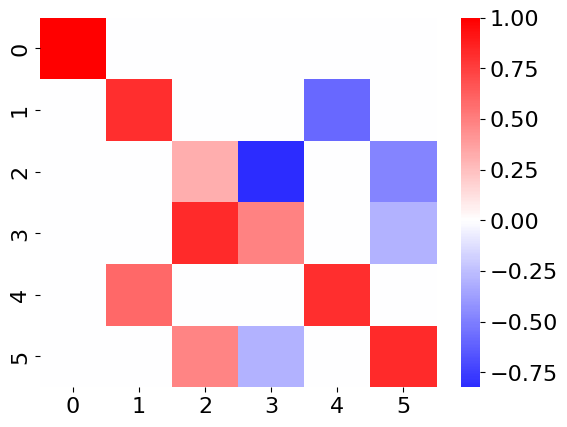

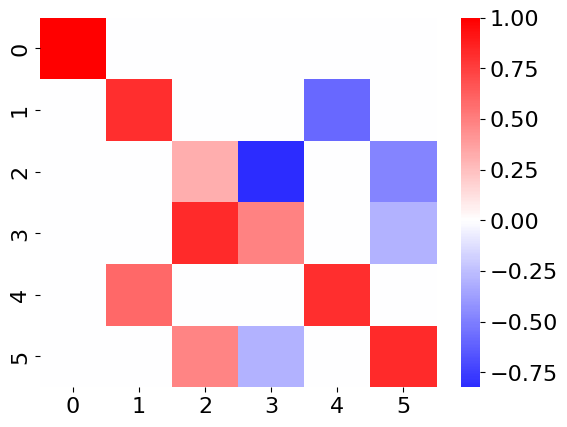

In [10]:
change_of_coord = torch.tensor([
    # this specifies the change of basis yzx -> xyz
    [0., 0., 1.],
    [1., 0., 0.],
    [0., 1., 0.]
])
D_aux = irreps_out.D_from_matrix(R).to(torch.float64)
D_aux
sns.heatmap(D_aux,center= 0, cmap = 'bwr')
plt.show()
change_of_coord = torch.tensor([
    # this specifies the change of basis yzx -> xyz
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.]
])
D_aux = irreps_out.D_from_matrix(R).to(torch.float64)
D_aux
sns.heatmap(D_aux,center= 0, cmap = 'bwr')
plt.show()

In [11]:
Y_lm_e3

tensor([ 2.3094,  0.0000,  0.0000, -0.4082,  0.0000,  0.7071])

In [27]:
X = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 2.0]
], dtype=torch.float64)

sph_coefs = cart2realsphvec(X)
Y_lm =  torch.tensor(sph_coefs.astype(float))
print(Y_lm)

Y_lm_transformed = Y_lm @ D_aux.to(torch.float64).T
print(Y_lm_transformed)
rotated_tensor = R.to(torch.float64) @ X @ R.to(torch.float64).T
sph_coefs = cart2realsphvec(rotated_tensor) 
Y_lm_rotated = torch.tensor(sph_coefs.astype(float))    
print(Y_lm_rotated)
diff = torch.norm(Y_lm_rotated - Y_lm_transformed)
print(diff)

tensor([1.1284, 0.0000, 0.0000, 0.6308, 0.0000, 0.0000])
tensor([ 1.1284e+00,  1.0058e-15, -5.1954e-01,  3.0389e-01, -6.3448e-16,
        -1.8873e-01])
tensor([1.1284, 0.0000, 0.0000, 0.6308, 0.0000, 0.0000])
tensor(0.6422)


# $\omega$ depdendent spectra transformation

In [13]:
data_file = '../dataset/symmetrized_permittivity.pkl'
ours, species_ours = load_data(data_file)
ours.head(5)

,folder,formula,structure,mp_id,bandgap,crystal_system,omega,real_Permittivity_Matrices,imag_Permittivity_Matrices,Re_00,...,Im_11,Im_12,Im_20,Im_21,Im_22,avg_re_trace,avg_im_trace,real_symmetrized_permittivity,imag_symmetrized_permittivity,species
0,/global/cfs/cdirs/m225/angush/materialProject/...,Li4Se8Y4,"(Atom('Li', [2.83855, 0.0, 2.88335], index=0),...",mp-37879,1.6604,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.481281668892605, -1.3506806366681457e-09,...","[[[-1.0722568410351282e-17, -2.371619162135055...","[3.481281668892605, 3.4813019889159484, 3.4813...",...,"[-1.4324565125840434e-17, 0.000203386314985097...","[-6.400276971094875e-19, 1.187453653061564e-12...","[1.3823342267093493e-17, 1.882754707806698e-12...","[-6.400276971094875e-19, 1.187453653061564e-12...","[3.342549740214423e-18, 0.0001803350567406132,...","[3.4405690641171667, 3.44058861685612, 3.44064...","[-7.234861265325764e-18, 0.0001957028760583553...","[[[3.4812758467294405, 0.0, -2.584939414228211...","[[[-1.2523566768095863e-17, 0.0, -4.8148248609...","[Y, Se, Li]"
1,/global/cfs/cdirs/m225/angush/materialProject/...,Mo3S2Se4,"(Atom('Mo', [1.636616366, 0.944882001641236, 3...",mp-1025906,0.5619,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[5.126763705823415, -0.0036857171285808207, ...","[[[3.2316203633511406e-17, 4.065761255667405e-...","[5.126763705823415, 5.1268254576594545, 5.1270...",...,"[2.017567602677919e-17, 0.0006175595714383959,...","[2.6785699480178126e-17, -7.1566796821889846e-...","[-9.092746101489361e-19, 1.2366187483073555e-0...","[2.6785699480178126e-17, -7.1566796821889846e-...","[5.356300432663947e-18, 0.00011878724682517897...","[4.321433518069999, 4.321478600797114, 4.32161...","[1.9282726697651513e-17, 0.0004517163617600133...","[[[5.124538605076387, 6.794333614242494e-18, 5...","[[[2.6245939830145304e-17, -2.5679065925163146...","[Se, S, Mo]"
2,/global/cfs/cdirs/m225/angush/materialProject/...,Li3NbS4,"(Atom('Li', [0.0, 0.0, 3.0251], index=0), Atom...",mp-755309,2.8348,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[1.7313146368871726, 7.054466462945285e-06, ...","[[[2.9669125906530276e-18, 2.117513176816877e-...","[1.7313146368871726, 1.7313217564659527, 1.731...",...,"[6.416846704309092e-18, 7.124085242430225e-05,...","[-1.0033425582785427e-17, 8.405343317085762e-1...","[3.969580319788735e-18, 8.535424337320327e-10,...","[-1.0033425582785427e-17, 8.405343317085762e-1...","[-6.4642318455671115e-18, 7.12408590969345e-05...","[1.7313150452437125, 1.7313221648231247, 1.731...","[9.731758164650026e-19, 7.124085259360446e-05,...","[[[1.7313150452437125, -3.529303946892918e-23,...","[[[9.73175816465002e-19, 0.0, 0.0], [0.0, 9.73...","[S, Nb, Li]"
3,/global/cfs/cdirs/m225/angush/materialProject/...,CdSe2Zn,"(Atom('Zn', [2.07525, 2.07525, 2.981], index=0...",mp-1017534,0.7236,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.2667371759234984, -3.486898178425755e-06,...","[[[-1.7162171221554744e-17, -4.972084285417574...","[3.2667371759234984, 3.266768077328808, 3.2668...",...,"[-5.209005378415435e-19, 0.0003101068789550751...","[-5.716867411329558e-18, 1.0499994209043163e-0...","[4.710222018194405e-18, 5.8322763388424595e-09...","[-5.716867411329558e-18, 1.0499994209043163e-0...","[-1.5461680231046413e-17, 0.000264086382651040...","[3.270700626888884, 3.270730008788789, 3.27081...","[-1.1048250663480898e-17, 0.000294768918248031...","[[[3.2667200732203123, 0.0, 0.0], [0.0, 3.2667...","[[[-8.841535879698145e-18, 0.0, -9.62964972193...","[Zn, Se, Cd]"
4,/global/cfs/cdirs/m225/angush/materialProject/...,Al8Te12,"(Atom('Al', [5.408683744491139, 4.382650362, 3...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.57865600493003, -2.773634699822434e-08, 0...","[[[-2.370171074423322e-18, -5.455394216331598e...","[3.57865600493003, 3.5786781470220483, 3.57874...",...,"[7.535756990354589e-18, 0.00024881623059193564...","[-2.45582483

In [14]:
row = ours[ours["mp_id"]=="mp-2422143"]
omega = row['omega'].iloc[0]
X  = torch.tensor(row['real_Permittivity_Matrices'].iloc[0])
Y_lm = x.from_cartesian(X)

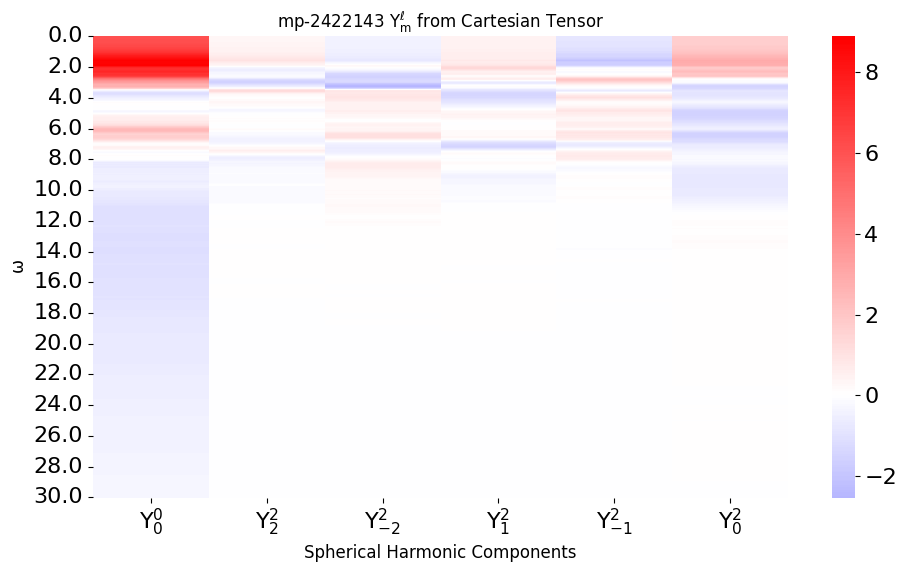

In [15]:
def plot_single_spherical_harmonic(Y_lm, component_ticks, omega, tick_step=2, title_prefix="", save_dir="../pngs"):
    """
    Plots a single heatmap for spherical harmonic coefficients (Y_lm) derived from a Cartesian tensor.

    Parameters:
    - Y_lm: 2D NumPy array of shape (n_omega, n_components) containing spherical harmonic coefficients.
    - component_ticks: List of LaTeX strings for x-axis labels (spherical harmonic components).
    - omega: 1D NumPy array of frequency values (e.g., np.linspace(0, 30, 3001)).
    - tick_step: Step size for omega ticks (e.g., 2 for every 2 omegas).
    - title_prefix: Prefix to be added to the plot title (e.g., Material ID).
    - save_dir: Directory to save the plot (default: "../pngs").
    """
    # Check dimensions
    n_omega, n_components = Y_lm.shape
    if len(omega) != n_omega:
        raise ValueError(f"Length of omega ({len(omega)}) must match Y_lm rows ({n_omega})")
    if len(component_ticks) != n_components:
        raise ValueError(f"Length of component_ticks ({len(component_ticks)}) must match Y_lm columns ({n_components})")

    # Compute sample indices and labels for y-axis ticks (every tick_step omegas)
    omega_min, omega_max = omega[0], omega[-1]
    sample_omegas = np.arange(omega_min, omega_max + tick_step, tick_step)  # e.g., [0, 2, ..., 30]
    # Map omega values to indices
    sample_indices = np.searchsorted(omega, sample_omegas)
    sample_labels = sample_omegas  # Labels are the omega values themselves

    # Setup figure
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(Y_lm, cmap='bwr', center=0, xticklabels=component_ticks)

    # Set title and labels
    plt.title(rf"{title_prefix} $Y^{{\ell}}_{{m}}$ from Cartesian Tensor", fontsize=12)
    plt.xlabel("Spherical Harmonic Components", fontsize=12)
    plt.ylabel(r"$\omega$", fontsize=12)

    # Set y-axis ticks and labels
    ax.set_yticks(sample_indices)
    ax.set_yticklabels([f"{label:.1f}" for label in sample_labels])

    # Rotate tick labels for readability
    ax.tick_params(axis='x', rotation=0)  # Horizontal x-axis labels
    ax.tick_params(axis='y', rotation=0)  # Horizontal y-axis labels

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/{title_prefix}_single_sph_harmonic.png"
    # plt.savefig(save_path, dpi=300)
    plt.show()

# Example usage
# Dummy data for demonstration
n_omega = 3001  # Number of frequency points
n_components = 6  # Number of spherical harmonic components
omega = np.linspace(0, 30, n_omega)  # Frequency range: 0 to 30
component_ticks = [r"$Y^0_0$", r"$Y^2_2$", r"$Y^2_{-2}$", r"$Y^2_1$", r"$Y^2_{-1}$", r"$Y^2_0$"]

# Call the function
plot_single_spherical_harmonic(Y_lm, component_ticks, omega, tick_step=2, title_prefix="mp-2422143")

In [16]:
import seaborn as sns

sample_ticks = np.arange(0,max(omega),1)
Y_lm_rotated_np = Y_lm_rotated.detach().cpu().numpy()
Y_lm_transformed_np = Y_lm_transformed.detach().cpu().numpy()
component_ticks = [r"$Y^0_0$", r"$Y^2_2$", r"$Y^2_{-2}$", r"$Y^2_1$", r"$Y^2_{-1}$", r"$Y^2_0$"]
sample_indices = np.linspace(0, 999, 11)  # 11 points from 0 to 999 (inclusive)
sample_labels = np.arange(0, 11, 1)  # Labels: 0, 1, 2, ..., 10

# Heatmap for Y_lm_rotated
plt.figure(figsize=(10, 6))
ax = sns.heatmap(Y_lm_rotated_np, cmap='bwr', center=0, xticklabels=component_ticks)
plt.title(r"$Y^{\ell}_{m}$ from Rotated X (R @ X @ R.T)")
ax.set_yticks(sample_indices)
ax.set_yticklabels(sample_labels)
plt.xlabel("Spherical Harmonic Components")
plt.ylabel(r"$\omega$")
plt.show()

# Heatmap for Y_lm_transformed
plt.figure(figsize=(10, 6))
ax = sns.heatmap(Y_lm_transformed_np, cmap='bwr', center=0, xticklabels=component_ticks)
plt.title(r"$Y^{\ell}_{m}$ from Rotated X (R @ X @ R.T)")
ax.set_yticks(sample_indices)
ax.set_yticklabels(sample_labels)
plt.title(r"Y^{\ell}_m Rotated by Wigner D-matrix")
plt.xlabel("Spherical Harmonic Components")
plt.ylabel(r"$\omega$")
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (6, 1) and (6,))

<Figure size 1000x600 with 0 Axes>

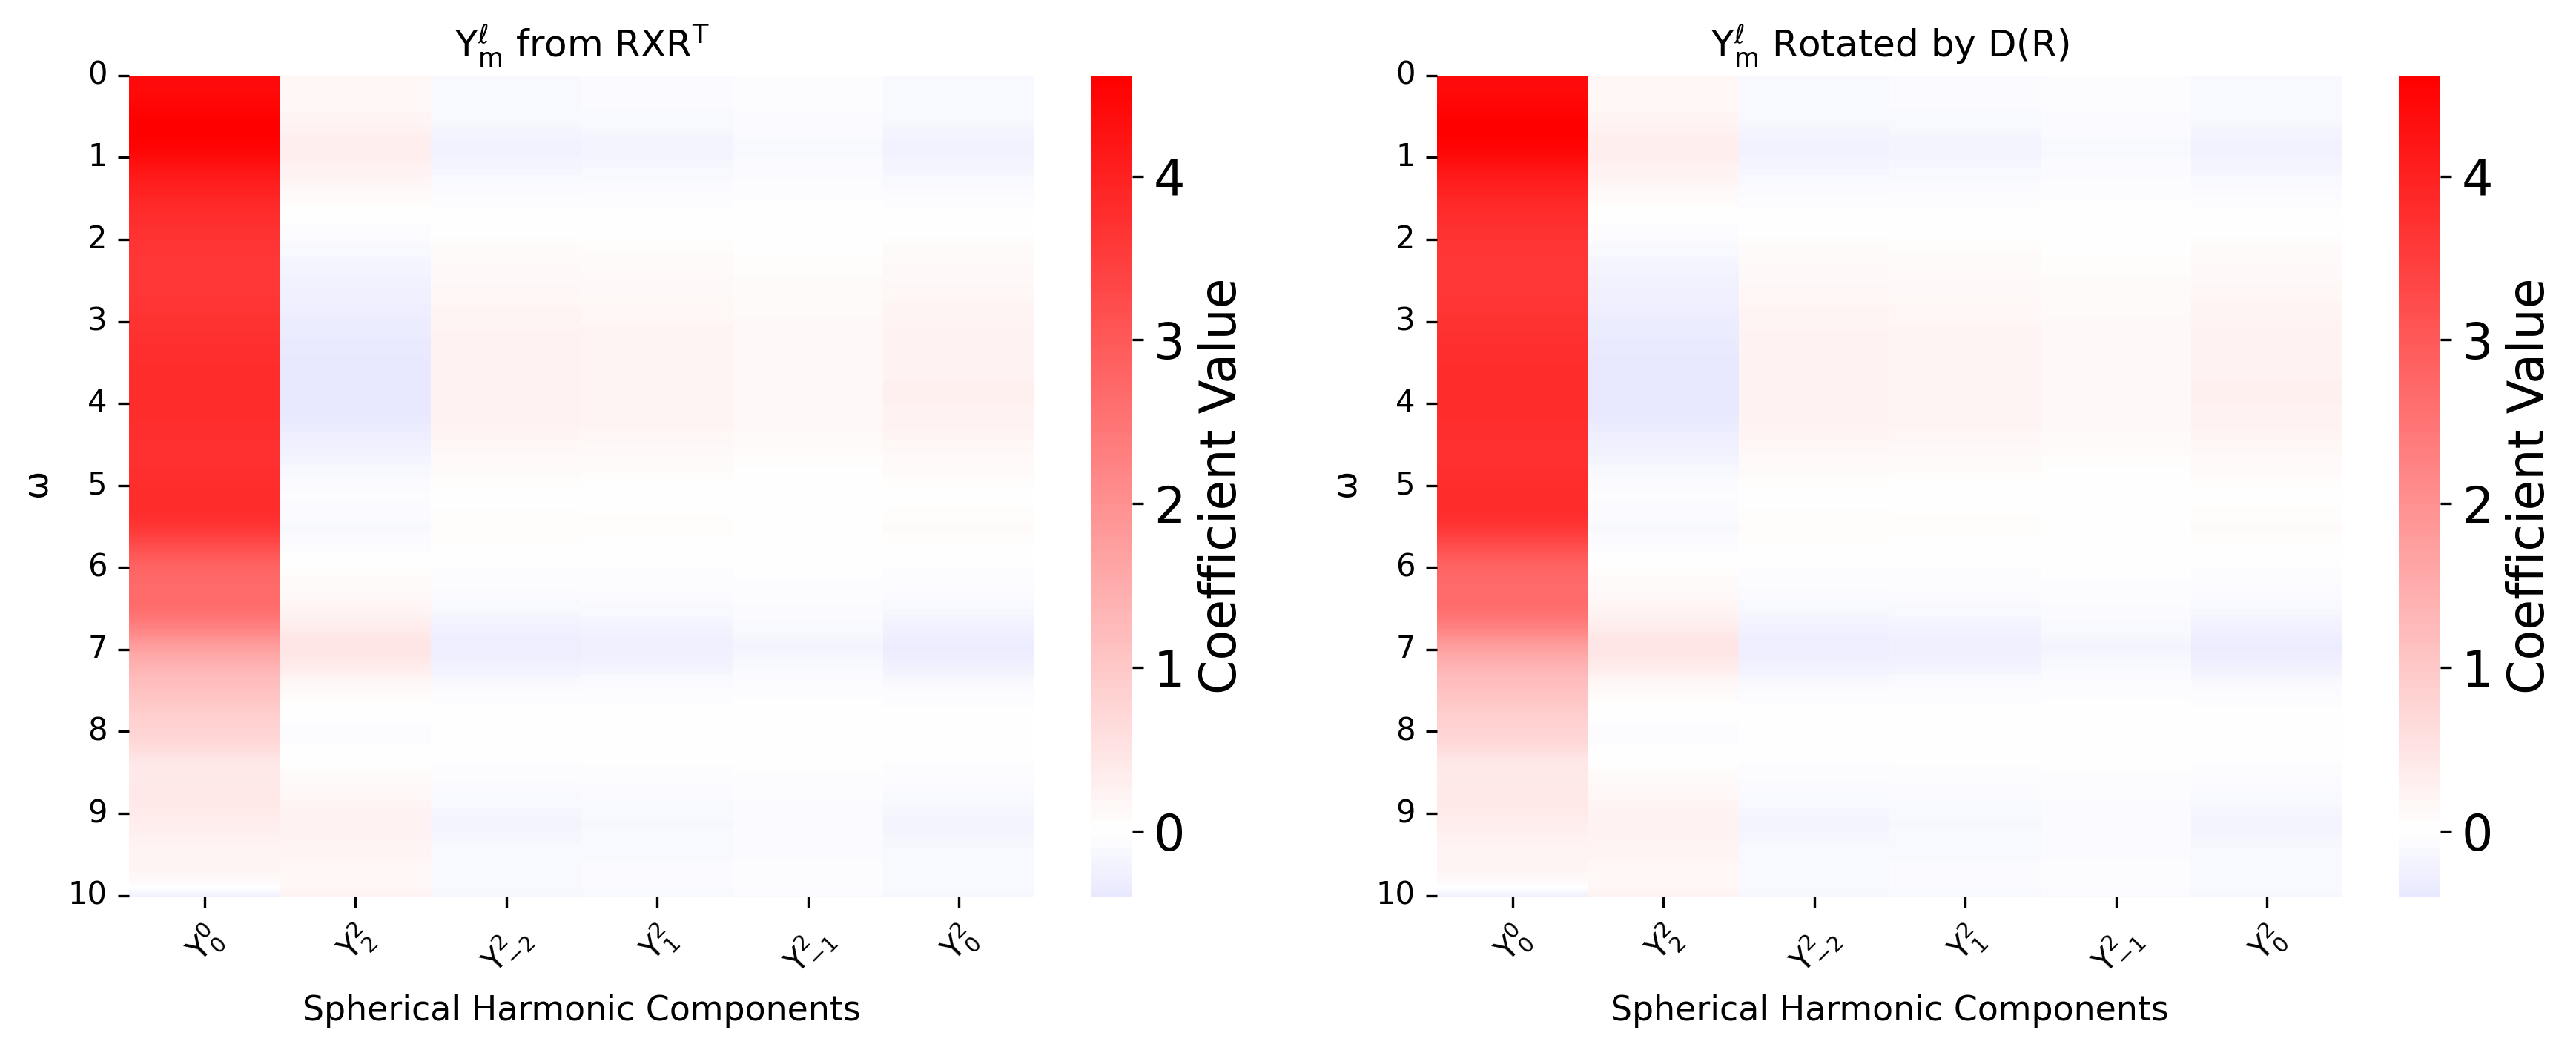

In [ ]:
# Set up figure with subplots side by side
plt.figure(figsize=(12, 5), dpi=300)  # Wide figure for side-by-side, high DPI for quality
component_ticks = [r"$Y^0_0$", r"$Y^2_2$", r"$Y^2_{-2}$", r"$Y^2_1$", r"$Y^2_{-1}$", r"$Y^2_0$"]

# Left subplot: Y_lm_rotated
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(Y_lm_rotated_np, cmap='bwr', center=0,xticklabels=component_ticks, cbar_kws={'label': 'Coefficient Value'})
ax1.set_xticklabels(component_ticks, rotation=45, fontsize=10)
ax1.set_yticks(sample_indices)
ax1.set_yticklabels(sample_labels, fontsize=10)
ax1.set_title(r"$Y^\ell_m$ from $RXR^T$", fontsize=12)
ax1.set_xlabel("Spherical Harmonic Components", fontsize=11)
ax1.set_ylabel(r"$\omega$", fontsize=11)

# Right subplot: Y_lm_transformed
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(Y_lm_transformed_np, cmap='bwr', center=0,xticklabels=component_ticks, cbar_kws={'label': 'Coefficient Value'})
ax2.set_xticklabels(component_ticks, rotation=45, fontsize=10)
ax2.set_yticks(sample_indices)
ax2.set_yticklabels(sample_labels, fontsize=10)
ax2.set_title(r"$Y^\ell_m$ Rotated by $D(R)$", fontsize=12)
ax2.set_xlabel("Spherical Harmonic Components", fontsize=11)
ax2.set_ylabel(r"$\omega$", fontsize=11)

# Adjust layout and save as EPS
plt.tight_layout()
plt.savefig("spherical_harmonics_comparison.eps", format='eps', bbox_inches='tight')
plt.show()

In [30]:
inv_perm = torch.argsort(perm)
inv_perm


tensor([2, 0, 1])